# Convolutional Neural Network 구현
- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교.

In [1]:
import matplotlib.pyplot as plt
# 학습결과 그래프 함수
# loss 그래프
def plot_loss(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [2]:
# accuracy 그래프
def plot_accuracy(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
import numpy as np

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

In [5]:
# 하이퍼파라미터 설정
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100
N_CLASS = 10

In [6]:
# 데이터셋 로드
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, train_label.shape, test_image.shape, test_label.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
# 추가 변수 설정
N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

In [8]:
# 전처리: 이미지 - 정규화(0 ~ 1)
#         label - one hot encoding(생략 - loss: sparse_categorical_crossentropy)
X_train, X_test = train_image/255, test_image/255
y_train, y_test = train_label, test_label

In [9]:
# 채널 축 늘려주기 -> 흑백 이미지의 경우, 채널축 없을 경우 늘려줌(CNN의 경우 채널 축까지 넣어줘야 하기 때문)
# (28, 28) -> (28, 28, 1)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [10]:
X_train.shape

(60000, 28, 28, 1)

In [11]:
# dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder = True).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

# CNN 모델 구성
- convolution layer의 filter 개수는 적은 개수에서 점점 늘려감
- input shape(입력 이미지의 size): 3차원(height, width, channel)
    - 흑백: (height, width, 1)
    - 컬러: (height, width, 3)
    

In [12]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Input((28, 28, 1)))  # Input shape
    
    # Convolution layer: Conv2D -> MaxPool2D
    model.add(layers.Conv2D(filters = 32,  # Filter 개수
                            kernel_size = (3,3),  # Filter(Kernel)의 height/width. h/w가 같은 경우에는 정수
                            padding = 'same',  # Padding 방식: 'valid', 'same' - 대소문자는 상관 없음
                            strides = (1, 1),  # Stride 설정: (상하, 좌우. 상하/좌우 같은 값이면 정수
                            activation = 'relu'))
    
    # Max Pooling layer => MaxPool2D
    model.add(layers.MaxPool2D(pool_size = (2,2),  # 영역 height, width 크기 지정. h/w 같으면 정수. default = (2,2). Feature map size를 절반으로 줄임
              strides = (2, 2),  # Default: None => pool_size를 사용. 2개 값이 같으면 정수
              padding = 'same'))  # 'valid': 뒤에 남는 것은 버림


    model.add(layers.Conv2D(filters = 64,
                            kernel_size = 3,
                            padding = 'same',
                            strides = 1,
                            activation = 'relu'))
    
    model.add(layers.MaxPool2D(padding = 'same'))  # pool_size, strides: default 값(2,2)으로 설정

    
    # Classification Layer -> Fully Connected Layer
    # Conv 거친 Feature map은 3차원 배열 -> Flatten(): 1차원 배열로 변환
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = 'relu'))
    # 출력
    model.add(layers.Dense(N_CLASS, activation = 'softmax'))

    return model

In [13]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

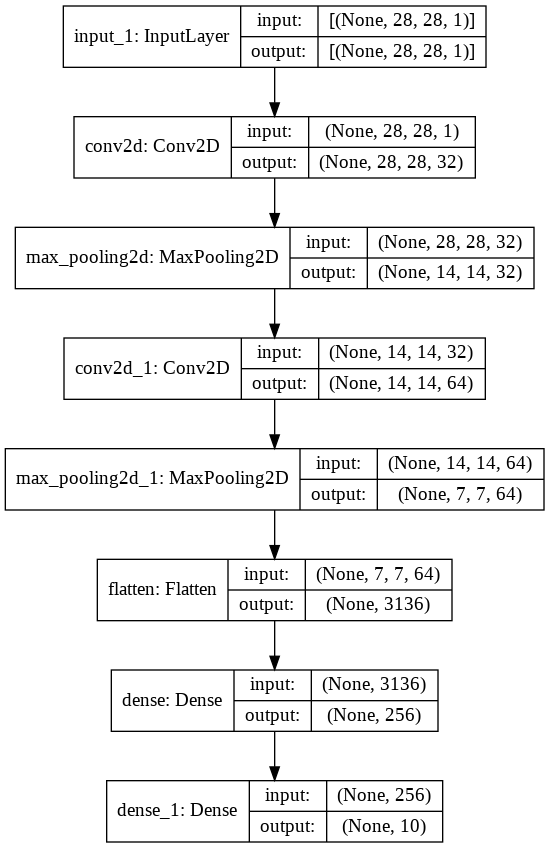

In [14]:
keras.utils.plot_model(model, show_shapes = True)

In [15]:
# 컴파일
model.compile(optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])  # sparse_categorical_crossentropy: y가 one hot encoding 안된 경우 사용

In [16]:
steps_per_epoch = N_TRAIN // N_BATCHS
validation_steps = int(np.ceil(N_TEST / N_BATCHS))

history = model.fit(train_dataset,
                    epochs = N_EPOCHS,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_dataset,
                    validation_steps = validation_steps)

Epoch 1/20
600/600 [==============================] - 36s 5ms/step - loss: 0.3779 - accuracy: 0.8822 - val_loss: 0.0425 - val_accuracy: 0.9860
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0456 - accuracy: 0.9864 - val_loss: 0.0347 - val_accuracy: 0.9897
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0279 - accuracy: 0.9915 - val_loss: 0.0274 - val_accuracy: 0.9907
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.0348 - val_accuracy: 0.9887
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.0252 - val_accuracy: 0.9916
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0135 - accuracy: 0.9957 - val_loss: 0.0325 - val_accuracy: 0.9905
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0090 - accuracy: 0.9968 - val_loss: 0.0332 - val_accuracy: 0.9898
Epoch

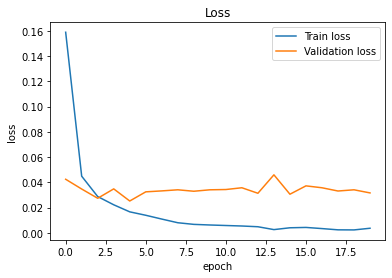

In [17]:
plot_loss(history)

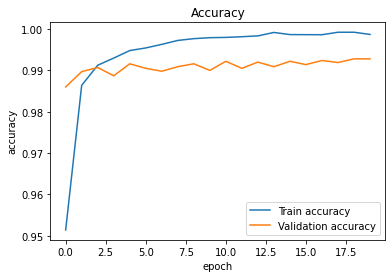

In [18]:
plot_accuracy(history)

In [19]:
X_test[:5].shape

(5, 28, 28, 1)

In [20]:
model.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0316 - accuracy: 0.9928


[0.03164314106106758, 0.9927999973297119]

In [21]:
# 새로운 데이터 추론
pred = model.predict(X_test[:10])
pred_class = np.argmax(pred, axis = 1)

In [22]:
pred_class, y_test[:10]

(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8))

### prediction error가 발생한 example 확인

In [23]:
pred = model.predict(X_test)
pred_class = np.argmax(pred, axis = 1)
pred_class[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [24]:
# pred_class: 예측결과, y_test: 실제 정답
# 예측이 틀린 index 조회
error_idx = np.where(pred_class != y_test)[0]
error_idx.size, error_idx

(72, array([  18,  115,  247,  321,  674,  684,  883,  947, 1014, 1112, 1226,
        1242, 1260, 1319, 1393, 1522, 1527, 1709, 1901, 2070, 2118, 2129,
        2130, 2135, 2293, 2369, 2447, 2597, 2654, 2742, 2771, 2938, 2939,
        2953, 3422, 3534, 3558, 3767, 3780, 3796, 3808, 3853, 3906, 3941,
        4176, 4199, 4201, 4740, 4761, 4783, 4860, 4911, 5201, 5331, 5634,
        5937, 5997, 6091, 6166, 6576, 6597, 6625, 7574, 8408, 9009, 9015,
        9664, 9669, 9692, 9729, 9792, 9839]))

In [25]:
pred_class != y_test

array([False, False, False, ..., False, False, False])

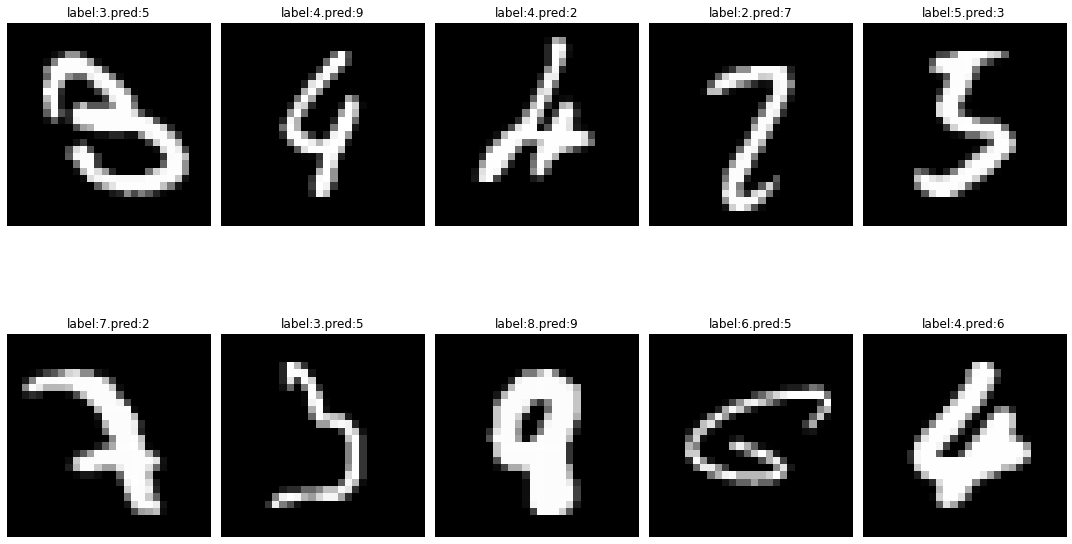

In [26]:
# 틀린 것 10개 확인
plt.figure(figsize = (15, 10))
for i in range(10):
    err = error_idx[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(test_image[err], cmap = 'gray')
    plt.title(f'label:{y_test[err]}.pred:{pred_class[err]}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()


# 모델 저장
1. 학습이 끝난 모델의 파라미터만 저장
1. 모델 전체 저장
1. Callback 함수를 이용해 학습시 가장 좋은 지표의 모델 저장

## 텐서플로 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 파일타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 형식

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있음
- 저장: `model.save_weights("저장경로")`
- 불러오기: `model.load_weights('불러올경로')`
     - 단, weight만 저장되어 있기에, 모델을 만든 상태에서 불러오기
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# 저장할 경로 생성
import os
# 모델/파라미터들을 저장할 root
base_dir = '/content/drive/MyDrive/saved models'
weight_dir = os.path.join(base_dir, 'mnist', 'weights')
print(weight_dir)

if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir, exist_ok = True)  # exist_ok = False(기본): 이미 경로가 있으면 예외발생. True: 예외발생 안시킴
weight_path = os.path.join(weight_dir, 'mnist_cnn_weights.ckpt')  # 저장할 디렉토리 + 파일명

/content/drive/MyDrive/saved models/mnist/weights


In [29]:
model.save_weights(weight_path)

In [30]:
new_model1 = create_model()
new_model1.compile(optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [31]:
new_model1.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3126 - accuracy: 0.1780


[2.313303232192993, 0.17180000245571136]

In [32]:
# 파일로 저장된 weight들을 생성된 모델(네트워크)에 저장
new_model1.load_weights(weight_path)

In [33]:
# 이어서 학습
new_model1.fit()

ValueError: ignored

#### hdf5 형식으로 저장/불러오기

In [34]:
weight_h5_dir = os.path.join(base_dir, 'mnist', 'weight_h5')
if not os.path.isdir(weight_h5_dir):
    os.makedirs(weight_h5_dir)
# 파일 디렉토리 만들기
weight_h5_path = os.path.join(weight_h5_dir, 'mnist_cnn_weight.h5')
print(type(weight_h5_path), weight_h5_path)

<class 'str'> /content/drive/MyDrive/saved models/mnist/weight_h5/mnist_cnn_weight.h5


In [35]:
model.save_weights(weight_h5_path, save_format = 'h5')

In [36]:
new_model2 = create_model()
new_model2.compile(optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [37]:
new_model2.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3159 - accuracy: 0.0876


[2.315847158432007, 0.08489999920129776]

In [38]:
new_model2.load_weights(weight_h5_path)
new_model2.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0316 - accuracy: 0.9928


[0.03164314106106758, 0.9927999973297119]

## 전체 모델 저장하고 불러오기
- 저장: `model.save('저장할디렉토리')`
- 불러오기: `tf.keras.models.load_model('저장파일경로')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장됨
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 로 지정
    

In [39]:
# SavedModel 형식
# 디렉터리 생성
model_dir = os.path.join(base_dir, 'mnist', 'models', 'saved_model')
if not os.path.isdir(model_dir):
    os.makedirs(model_dir, exist_ok = True)
print(model_dir)

/content/drive/MyDrive/saved models/mnist/models/saved_model


In [40]:
# SaveModel 형식으로 지정시 디렉토리 지정
model.save(model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved models/mnist/models/saved_model/assets


In [41]:
# SaveModel 읽어오기
new_model3 = keras.models.load_model(model_dir)

In [42]:
new_model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [43]:
# 결과도 동일하게 나옴
new_model3.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0316 - accuracy: 0.9928


[0.03164314106106758, 0.9927999973297119]

In [44]:
# h5 형식으로 저장/불러오기
model_h5_dir = os.path.join(base_dir, 'mnist', 'models', 'h5_model')
if os.path.isdir(model_h5_dir):
    os.makedirs(model_h5_dir, exist_ok = True)
# h5 형식으로 저장할때 파일명까지 저장해야됨
model_h5_path = os.path.join(model_h5_dir, 'mnist_cnn_model.h5')

In [45]:
model.save(model_h5_path, save_format = 'h5')

In [46]:
new_model4 = keras.models.load_model(model_h5_path)

In [48]:
new_model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [49]:
new_model4.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0316 - accuracy: 0.9928


[0.03164314106106758, 0.9927999973297119]

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시, 호출되는 다양한 함수를 제공하여 자동화 처리 지원함(cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공됨
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- `EarlyStopping`: Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈춤
    - `monitor`: 모니터링할 평가지표 지정(ex: accuracy)
    - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단
- `ModelCheckpoint`: 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight를 저장하여 overfitting이 발생하기 전의 model을 나중에 불러들여 사용할 수 있음
    - 매 epoch마도 저장할 수도 있으며, 가장 성능 높을 때만 저장할 수도 있음
    - 모델만 저장할 수도 있으며, 가중치만 빼서 저장할 수도 있음
    - `save_best_only=True`: monitoring 중인 measure를 기준으로 최적의 모형의 weight만 저장 
- **callback 객체들을 리스트로 묶은 뒤 fit()의 callback 매개변수에 전달**

In [50]:
model2 = create_model()
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [51]:
model2.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.2994 - accuracy: 0.1350


[2.3011434078216553, 0.12770000100135803]

In [52]:
callback_dir = os.path.join(base_dir, 'mnist', 'models', 'callback')
if not os.path.isdir(callback_dir):
    os.makedirs(callback_dir, exist_ok = True)

callback_path = os.path.join(callback_dir, 'saved_model_{epoch:02d}.ckpt')  # {epoch:02d} - 포맷문자열. 몇번째 에폭때 저장인지

In [53]:
# 채울값(0) 자릿수(5) 정수(d) 실수(f)
'{age}, {price:05d}'.format(age = 1, price = 2)
'{age:.2f},{price:05d}'.format(age = 0.12313123, price = 2)

'0.12,00002'

In [63]:
# ModelCheckpoint callback 생성
mc_callback = keras.callbacks.ModelCheckpoint(filepath = callback_path,  # 학습 도중 모델/파라미터를 저장할 경로
                                              save_weights_only = True,  # True: 가중치만 저장. False(기본): 모델 + 가중치
                                              save_best_only = True,  # True: 가장 성능 좋았을 때만 저장. False(기본): 매 에폭마다 저장
                                              monitor = 'val_loss',  # save_best_only = True 일때, 성능 확인할 평가지표
                                              verbose = 1)  # 저장할 때마다 로그를 출력

# Early Stopping callback 생성
es_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 5)  # 5번 애폭 학습하는 동안 val_loss가 좋아지지 않으면 학습을 멈춰라)

In [64]:
model2.fit(train_dataset,
           epochs = N_EPOCHS,
           steps_per_epoch = steps_per_epoch,
           validation_data = test_dataset,
           validation_steps = validation_steps,
           callbacks = [mc_callback, es_callback])

Epoch 1/20
600/600 [==============================] - 4s 6ms/step - loss: 8.1719e-06 - accuracy: 1.0000 - val_loss: 0.0325 - val_accuracy: 0.9938

Epoch 00001: val_loss improved from inf to 0.03246, saving model to /content/drive/MyDrive/saved models/mnist/models/callback/saved_model_01.ckpt
Epoch 2/20
600/600 [==============================] - 4s 6ms/step - loss: 5.4931e-06 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 0.9936

Epoch 00002: val_loss did not improve from 0.03246
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - loss: 4.0003e-06 - accuracy: 1.0000 - val_loss: 0.0338 - val_accuracy: 0.9937

Epoch 00003: val_loss did not improve from 0.03246
Epoch 4/20
600/600 [==============================] - 4s 6ms/step - loss: 2.9423e-06 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9939

Epoch 00004: val_loss did not improve from 0.03246
Epoch 5/20
600/600 [==============================] - 4s 6ms/step - loss: 2.2600e-06 - accuracy: 1.0000 - val_los

In [59]:
# 저장된 weight loading
new_model5 = create_model()
new_model5.compile(optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']) 

In [60]:
# weight들이 저장된 디렉토리를 저장하면, 마지막 에폭에서 저장된 weight를 불러옴
best_weights = tf.train.latest_checkpoint(callback_dir)

In [61]:
new_model5.load_weights(best_weights)

In [62]:
new_model5.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 0.0293 - accuracy: 0.9904


[0.024682430550456047, 0.9918000102043152]